# Applying logistic regression in python to discriminate between control and M. bovis infected animals using peripheral blood transcriptomics data from kirsten et al., 2021
### This analysis considers two approaches, one using logistic regression on variable genes that have been preprocessed using DESeq2 (vst normalised) and the other using latent variables inferred using PCA, ICA and NMF

In [46]:
## Load in all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from scipy import stats
from scipy.stats import kurtosis

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,roc_curve,auc, make_scorer,mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, PredefinedSplit
from sklearn.decomposition import PCA, NMF, FastICA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
import warnings
import pickle
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')

#font for plots
font = {'fontname':'Arial'}

In [47]:
kirsten_data_raw = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_individual/kirsten_vst_normalised_data.txt", sep = "\t").T


In [48]:
kirsten_data_raw = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_individual/kirsten_vst_normalised_data.txt", sep = "\t").T
kirsten_labels = pd.read_csv("/home/workspace/jogrady/ML4TB/data/kirsten/kirsten_samples.csv", sep = "\t")
kirsten_labels = kirsten_labels[["Animal_Code", "Week", "Status"]].drop_duplicates()
np.array(kirsten_labels["Animal_Code"]) == np.array(kirsten_data_raw.index)
kirsten_labels["ID"] = kirsten_labels["Animal_Code"].str.extract(r"(A\d{4})", expand=False)
kirsten_labels["Fold"] = kirsten_labels.groupby("ID").ngroup()
# Check right order
np.array(kirsten_labels["Animal_Code"]) == np.array(kirsten_data_raw.index)

kirsten_labels_simple = kirsten_labels["Status"].to_numpy()
kirsten_folds = kirsten_labels["Fold"].to_numpy()


kirsten_labels_simple = np.where(kirsten_labels_simple == "Control", 0, np.where(kirsten_labels_simple == "Infected", 1, kirsten_labels_simple))
kirsten_labels_simple = kirsten_labels_simple.astype(int)

In [49]:
# Calcualte variances for VST normalised genes
variances = kirsten_data_raw.var(axis=0)
# take top 20% and filter
threshold = variances.quantile(.80) 
genes = variances > threshold
genes= genes.loc[genes==True].index
kirsten_data = kirsten_data_raw.filter(items = genes, axis=1)

In [50]:
kirsten_data.head()

,SMIM11,ZBTB21,ITSN1,ABCG1,TFF2,TMPRSS3,RSPH1,IL1RAP,SLC37A1,P3H2,...,ENSBTAG00000054086,ENSBTAG00000050585,ENSBTAG00000052194,ENSBTAG00000053934,SERPINB4,ENSBTAG00000050153,ENSBTAG00000052012,MAD2L1,ENSBTAG00000054081,ENSBTAG00000049569
A6511_W-1,6.966160,8.037194,8.752079,9.421209,5.665151,5.263419,5.339643,9.156109,9.298534,5.521635,...,6.470850,5.859099,5.665151,6.734723,6.346728,5.748045,5.053554,7.354211,5.786630,6.583270
A6514_W-1,7.530962,7.530962,8.413710,9.466724,4.764618,4.764618,5.249967,7.779656,9.064442,5.501468,...,6.428989,5.863985,6.121726,6.503596,5.795944,5.551156,4.764618,7.237631,5.722225,5.249967
A6520_W-1,6.977538,7.692023,8.622618,9.638544,5.473673,5.034926,5.422001,8.295739,9.161759,6.252824,...,6.231887,5.791248,5.608571,6.231887,5.146336,5.942270,4.764618,7.302223,5.302897,5.608571
A6526_W-1,7.369448,7.936618,8.616556,9.603629,5.136714,4.764618,5.663960,7.974058,9.548575,5.766236,...,6.257961,5.028093,5.733513,6.387568,5.828215,4.764618,5.219716,7.530778,5.350551,6.581071
A6635_W-1,7.252932,7.870503,8.601384,8.891924,6.252159,5.554408,5.897229,8.982321,9.372737,5.294756,...,6.402719,6.004498,5.635428,6.551778,5.776164,5.743141,4.764618,7.323582,5.672943,6.291702


In [51]:
# Convert the custom folds array to a PredefinedSplit object
ps = PredefinedSplit(test_fold=kirsten_folds)

In [52]:

# Make a pipeline for logistic regression and set the paramaters
log_pipe = Pipeline(steps=[
('scaler', StandardScaler()), # see comment above (in markdown)
('classifier', LogisticRegression(max_iter=10000, solver='saga', tol=0.0001, random_state=42))]) # classifier

precision_scorer = make_scorer(precision_score, zero_division=1)  # had to modify zero_division as it was giving problems
f1_scorer = make_scorer(f1_score)
accuracy_scorer = make_scorer(accuracy_score)
recall_scorer = make_scorer(recall_score)

# Define scoring dictionary for GridSearchCV
scoring = {
    'accuracy': accuracy_scorer,
    'f1': f1_scorer,
    'precision': precision_scorer,
    'recall': recall_scorer
}

# Create a parameter grid - we will search through all these combinations
param_grid = {
    'classifier__penalty': ["elasticnet"],
    'classifier__l1_ratio': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
}
 
# Create GridSearchCV object
grid_search = GridSearchCV(log_pipe, param_grid, cv=ps, verbose=1, n_jobs=60, scoring=scoring, refit="accuracy")

In [53]:
grid_search.fit(kirsten_data, kirsten_labels_simple)

Fitting 9 folds for each of 10 candidates, totalling 90 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 4, 5,
       6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0,
       1, 2, 3, 4, 5, 6, 7, 8])),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=60,
             param_grid={'classifier__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9, 1],
                         'classifier__penalty': ['elasticnet']},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score, zero_division=1),
                      'recall': make_scorer(recall_score)},
             verbose=1)

In [54]:
non_zero_counts = []
for params, mean_score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_accuracy']):
    # Manually fit the pipeline with the parameters
    model = log_pipe.set_params(**params)
    model.fit(kirsten_data, kirsten_labels_simple)  # Re-fit the model on the entire dataset
    non_zero_count = np.sum(model.named_steps['classifier'].coef_ != 0)
    non_zero_counts.append((params, mean_score, non_zero_count))

non_zero_counts_df = pd.DataFrame(non_zero_counts)

non_zero_counts_df

,0,1,2
0,"{'classifier__l1_ratio': 0.1, 'classifier__pen...",0.729630,2056
1,"{'classifier__l1_ratio': 0.2, 'classifier__pen...",0.748148,1020
2,"{'classifier__l1_ratio': 0.3, 'classifier__pen...",0.840741,619
3,"{'classifier__l1_ratio': 0.4, 'classifier__pen...",0.822222,466
4,"{'classifier__l1_ratio': 0.5, 'classifier__pen...",0.862963,308
5,"{'classifier__l1_ratio': 0.6, 'classifier__pen...",0.925926,184
6,"{'classifier__l1_ratio': 0.7, 'classifier__pen...",0.907407,142
7,"{'classifier__l1_ratio': 0.8, 'classifier__pen...",0.925926,115
8,"{'classifier__l1_ratio': 0.9, 'classifier__pen...",0.944444,96
9,"{'classifier__l1_ratio': 1, 'classifier__penal...",0.944444,87


In [55]:
non_zero_counts_df = non_zero_counts_df.rename(columns={0: "Paramaters", 1: "Average Accuracy", 2: "Non-zero coefficeints"})

In [56]:
# Look at best paramaters and accuracy and save results to a data frame
print("Best Parameters:", grid_search.best_params_)
print(f"Best CV average accuracy: {grid_search.best_score_:.3f}")
results_genes = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),
           pd.DataFrame(grid_search.cv_results_["mean_test_accuracy"], columns = ["Average Accuracy"]),
           pd.DataFrame(grid_search.cv_results_["std_test_accuracy"], columns=["SD accuracy"]),
           pd.DataFrame(grid_search.cv_results_["mean_test_precision"], columns = ["Average precision"]),
           pd.DataFrame(grid_search.cv_results_["std_test_precision"], columns=["SD precision"]),
           pd.DataFrame(grid_search.cv_results_["mean_test_recall"], columns=["Average recall"]),
           pd.DataFrame(grid_search.cv_results_["std_test_recall"], columns=["SD recall"])],axis=1)

results_genes = pd.concat([results_genes, non_zero_counts_df.loc[:,["Non-zero coefficeints"]]], axis=1)
results_genes.sort_values(by='Average Accuracy', inplace=True)
results_genes

Best Parameters: {'classifier__l1_ratio': 0.9, 'classifier__penalty': 'elasticnet'}
Best CV average accuracy: 0.944


,classifier__l1_ratio,classifier__penalty,Average Accuracy,SD accuracy,Average precision,SD precision,Average recall,SD recall,Non-zero coefficeints
0,0.1,elasticnet,0.729630,0.224128,1.000000,0.000000,0.672222,0.273974,2056
1,0.2,elasticnet,0.748148,0.225044,1.000000,0.000000,0.694444,0.275322,1020
3,0.4,elasticnet,0.822222,0.198139,0.981481,0.052378,0.805556,0.254345,466
2,0.3,elasticnet,0.840741,0.205947,1.000000,0.000000,0.805556,0.254345,619
4,0.5,elasticnet,0.862963,0.143539,0.981481,0.052378,0.855556,0.183249,308
6,0.7,elasticnet,0.907407,0.114156,0.962963,0.069290,0.933333,0.133333,142
5,0.6,elasticnet,0.925926,0.114156,0.981481,0.052378,0.933333,0.133333,184
7,0.8,elasticnet,0.925926,0.082817,0.962963,0.069290,0.955556,0.083148,115
8,0.9,elasticnet,0.944444,0.078567,0.962963,0.069290,0.977778,0.062854,96
9,1.0,elasticnet,0.944444,0.078567,0.962963,0.069290,0.977778,0.062854,87


In [57]:
results_genes
results_genes.to_csv("/home/workspace/jogrady/ML4TB/results/Logistic_regression/CV_results/Kirsten_gene_CV_results.txt")

In [58]:
data_test = pd.DataFrame(zip(kirsten_data.columns, np.transpose(grid_search.best_estimator_.named_steps["classifier"].coef_)), columns=['features', 'coef'])#.sort_values(by='coef', inplace=True)
data_test.sort_values(by='coef', inplace = True)
data_test = data_test.loc[(data_test != 0).all(axis=1), :]
data_test.shape

(96, 2)

In [59]:
params = {'classifier__l1_ratio': 0.9, 'classifier__penalty': 'elasticnet'}
model = log_pipe.set_params(**params)
model.fit(kirsten_data, kirsten_labels_simple)  # Re-fit the model on the entire dataset

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(l1_ratio=0.9, max_iter=10000,
                                    penalty='elasticnet', random_state=42,
                                    solver='saga'))])

In [60]:
# Save model in case we ever need it again e.g. for external data
with open('/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Kirsten_Logistic_regression_l10.9_search.pkl', 'wb') as f:
    pickle.dump(model, f)

# PCA

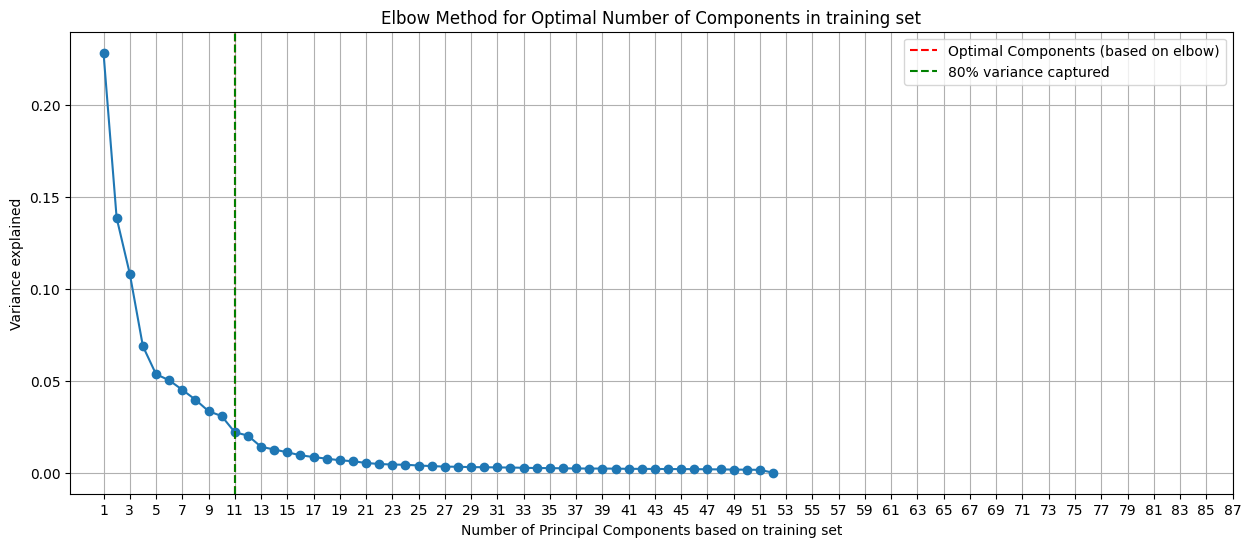

Variance captured by 11 PCs:0.82


In [61]:
 
# Do not need to scale for PCA - not recommended in VST
pca = PCA(random_state=88, n_components=52)
pca.fit(kirsten_data)
explained_variance = pca.explained_variance_ratio_
# Plotting the elbow curve
plt.figure(figsize=(15, 6))
plt.plot(range(1, 52+1), explained_variance, marker='o')
plt.xlabel('Number of Principal Components based on training set')
plt.ylabel('Variance explained')
plt.title('Elbow Method for Optimal Number of Components in training set')
plt.grid()
plt.xticks(range(1, 87 + 1,2))
plt.axvline(x=11, color='r', linestyle='--', label='Optimal Components (based on elbow)')
plt.axvline(x=11, color='g', linestyle='--', label='80% variance captured')
plt.legend()
plt.show()
print(f'Variance captured by 11 PCs:{pca.explained_variance_ratio_[:11].sum():.2f}')

In [62]:
# Set up the pipeline
PCA_Pipeline = Pipeline(steps=[('pca', PCA(random_state=42)),
('classifier', LogisticRegression(max_iter=10000, penalty="none", solver='saga', tol=0.0001, random_state=42))])

# Set up a grid for each PC
pca_param_grid = {'pca__n_components': list(range(1, 12))}

# Apply
LR_pca_search_model = GridSearchCV(PCA_Pipeline, pca_param_grid, cv=ps, scoring=scoring, refit="accuracy")

# Fit
LR_pca_search_model.fit(kirsten_data, kirsten_labels_simple.ravel())

GridSearchCV(cv=PredefinedSplit(test_fold=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 4, 5,
       6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0,
       1, 2, 3, 4, 5, 6, 7, 8])),
             estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000,
                                                           penalty='none',
                                                           random_state=42,
                                                           solver='saga'))]),
             param_grid={'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score, zero_division=1),
                      'recall': make_scorer(recall_score)})

In [63]:
# Look at best paramaters and accuracy and save results to a data frame
print(f"Best Paramater:", LR_pca_search_model.best_params_)
print(f"Best Score: {LR_pca_search_model.best_score_:.2f}")
results_pca = pd.concat([pd.DataFrame(LR_pca_search_model.cv_results_["params"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["mean_test_accuracy"], columns = ["CV Accuracy"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["std_test_accuracy"], columns=["SD accuracy"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["mean_test_precision"], columns = ["CV precision"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["std_test_precision"], columns=["SD precision"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["mean_test_recall"], columns=["CV recall"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["std_test_recall"], columns=["SD recall"])],axis=1)
results_pca.sort_values(by='CV Accuracy', inplace=True)

Best Paramater: {'pca__n_components': 9}
Best Score: 0.92


In [64]:
with open('/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Kirsten_Logistic_regression_PCA_search.pkl', 'wb') as f:
    pickle.dump(LR_pca_search_model, f)

In [65]:
print(results_pca)
results_pca.to_csv(path_or_buf="/home/workspace/jogrady/ML4TB/results/Logistic_regression/CV_results/Kirsten_PCA_CV_results.txt", sep = "\t")

    pca__n_components  CV Accuracy  SD accuracy  CV precision  SD precision  \
0                   1     0.807407     0.051587      0.822222      0.015713   
3                   4     0.807407     0.122502      0.835185      0.064043   
1                   2     0.825926     0.013858      0.825926      0.013858   
2                   3     0.825926     0.079780      0.840741      0.058326   
4                   5     0.885185     0.158785      0.912963      0.099931   
5                   6     0.885185     0.158785      0.912963      0.099931   
6                   7     0.903704     0.161356      0.931481      0.098897   
7                   8     0.903704     0.161356      0.931481      0.098897   
10                 11     0.903704     0.117004      0.937037      0.089504   
8                   9     0.922222     0.117589      0.937037      0.089504   
9                  10     0.922222     0.117589      0.937037      0.089504   

    CV recall  SD recall  
0    0.977778   0.062854

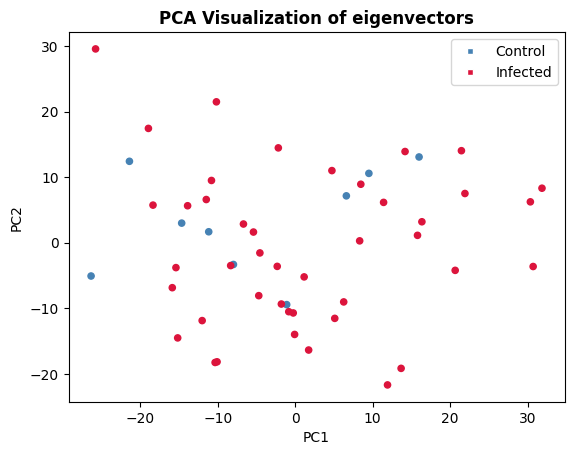

,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Component_7,Component_8,Component_9,Component_10,Component_11
0,STEAP4,ENSBTAG00000006383,CXCL3,ENSBTAG00000054774,DNER,DNER,FBN1,ENSBTAG00000050515,PRSS2,ENSBTAG00000006383,ENSBTAG00000052270
1,SLC1A1,SLC1A1,CXCL2,ENSBTAG00000009656,ENSBTAG00000037421,ENSBTAG00000032057,ENSBTAG00000026070,ENSBTAG00000054086,RGS2,ENSBTAG00000050398,ENSBTAG00000054241
2,ENSBTAG00000051635,ENSBTAG00000054774,GRO1,ENSBTAG00000052511,CXCL8,ENSBTAG00000053508,ENSBTAG00000032057,ENSBTAG00000039714,CLU,CBLIF,ENSBTAG00000049995
3,ENSBTAG00000053536,ENSBTAG00000053536,PRSS2,ENSBTAG00000052270,CRCP,FBN1,ENSBTAG00000022715,ENSBTAG00000054768,ENSBTAG00000011961,TPM1,ENSBTAG00000053508
4,ENSBTAG00000048577,ADGRV1,PTGS2,CXCL3,CXCL2,CXCL8,ENSBTAG00000052511,ENSBTAG00000050510,ENSBTAG00000054209,RADX,ENSBTAG00000047764
...,...,...,...,...,...,...,...,...,...,...,...
5517,IFI47,NR4A3,KMT2A,ENSBTAG00000045580,BOLA-DQB,ENSBTAG00000054768,ENSBTAG00000050846,HBB,FAT1,LRATD1,SERPINB2
5518,ENSBTAG00000052397,ENSBTAG00000048835,ENSBTAG00000053508,CBLIF,ENSBTAG00000049995,BOLA-DQA5,BOLA-DQA5,ENSBTAG00000053508,ENSBTAG00000024272,CYP2J30,ENSBTAG00000006383
5519,ENSBTAG00000047121,RGS2,ENSBTAG00000037421,BRB,ENSBTAG00000054774,ENSBTAG00000006383,ENSBTAG00000045580,ENSBTAG00000039524,HBA,ENSBTAG00000047449,ENSBTAG00000008328
5520,ENSBTAG00000047529,ENSBTAG00000009656,CRCP,ENSBTAG00000039524,BOLA-DQA5,ENSBTAG00000009656,ENSBTAG00000009656,ENSBTAG00000024272,SULT1C4,ENSBTAG00000037937,SULT1C4


In [66]:
# 'residuals_all.columns' contains the names of the genes

pca = PCA(random_state=42, n_components=11)
pca_fit = pca.fit(kirsten_data)
comp_genes= []
pca_genes = pd.DataFrame()
pca_results = pca_fit.fit_transform(kirsten_data)
colors = ['steelblue' if label == 0 else 'crimson' for label in kirsten_labels_simple.ravel()]
plt.scatter(pca_results[:, 0], pca_results[:, 1], label="Training data", c=colors, s=20)
handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='steelblue', markersize=5, label='Control'),
           plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='crimson', markersize=5, label='Infected')]
plt.title("PCA Visualization of eigenvectors", fontweight='bold')
plt.legend(handles=handles)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
# Iterate through each component
for component_idx in range(11):
    # Calculate loadings for the current component
    loadings = pca_fit.components_.T * np.sqrt(pca_fit.explained_variance_)

    # Sort genes by their influence on the current component
    sorted_genes = kirsten_data.columns[np.argsort(loadings[:, component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = pca_fit.components_.shape[1]
    top_genes = sorted_genes[-N:]

    pca_genes[component_idx] = top_genes[::-1]
    comp_genes = np.append(comp_genes, top_genes)
pca_genes.columns = ["Component_1","Component_2","Component_3","Component_4",
                     "Component_5","Component_6","Component_7","Component_8",
                     "Component_9","Component_10","Component_11"]                      
pca_genes 

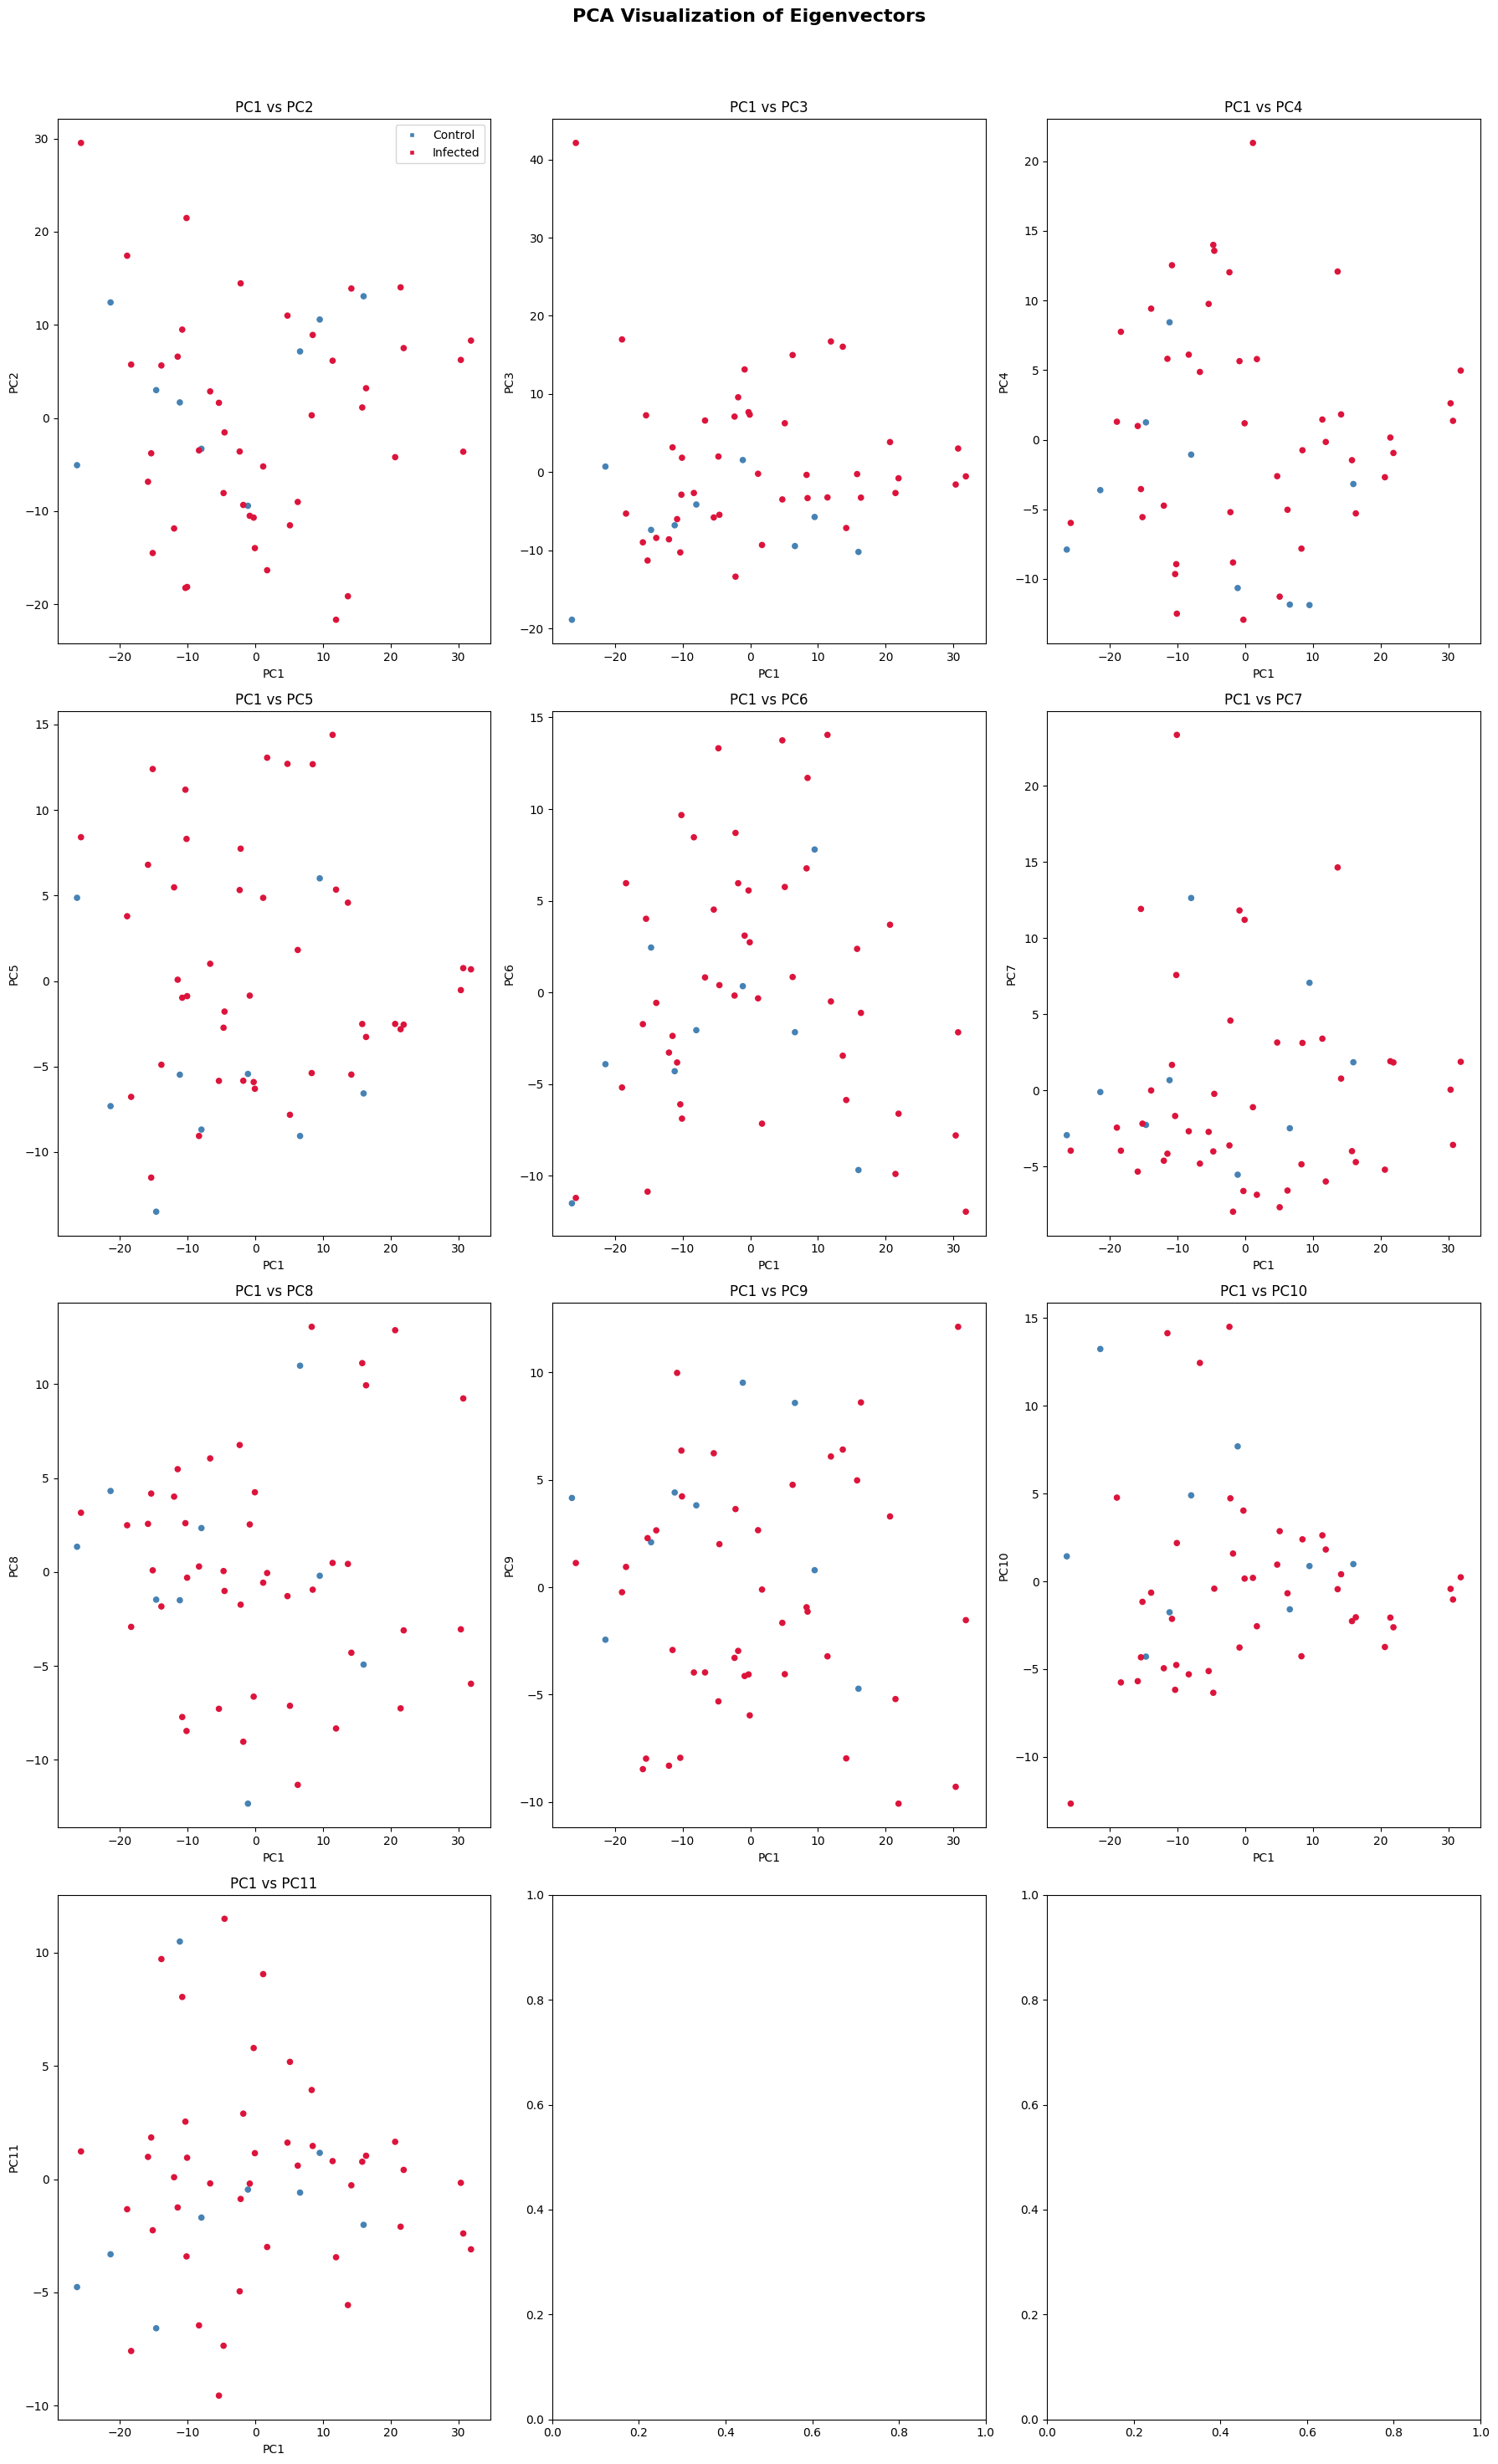

In [67]:
# Set up the grid for subplots (10 rows, 3 columns)
fig, axes = plt.subplots(4, 3, figsize=(18, 30))
fig.suptitle("PCA Visualization of Eigenvectors", fontweight='bold', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop to generate scatter plots from PC1 vs each PC up to PC30
for i in range(1, 11):
    ax = axes[i-1]
    ax.scatter(pca_results[:, 0], pca_results[:, i], c=colors, s=20)
    ax.set_title(f"PC1 vs PC{i+1}")
    ax.set_xlabel("PC1")
    ax.set_ylabel(f"PC{i+1}")

# Custom legend only in the first subplot (for cleanliness)
handles = [
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='steelblue', markersize=5, label='Control'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='crimson', markersize=5, label='Infected')
]
axes[0].legend(handles=handles)

# Hide any unused subplots (since there are only 29 plots for a 30-slot grid)
for j in range(12, len(axes)):
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()

In [68]:
Feature_weight_pca = pd.DataFrame(zip(pca_genes.columns, np.transpose(LR_pca_search_model.best_estimator_.named_steps["classifier"].coef_)), columns=['features', 'coef'])#.sort_values(by='coef', inplace=True)
Feature_weight_pca.sort_values(by='coef', inplace = True)
Feature_weight_pca = Feature_weight_pca.loc[(Feature_weight_pca != 0).all(axis=1), :]
Feature_weight_pca
# PC 5 is very important in the model

,features,coef
8,Component_9,[-0.1536229814725045]
1,Component_2,[-0.09656089257102522]
6,Component_7,[0.005335055306010469]
7,Component_8,[0.0378050997469965]
0,Component_1,[0.06783561227402385]
5,Component_6,[0.12345426237758426]
2,Component_3,[0.2580868247775254]
3,Component_4,[0.2858536843724216]
4,Component_5,[0.34128693190410003]


In [69]:
df_pca = pd.DataFrame(pca_results)
Control = df_pca.iloc[:8, :] # 45 samples in control
Infected = df_pca.iloc[9:, :] # 42 in infected

# Perform t-test for each component
results = pd.DataFrame(columns=['Component', 'T-Statistic', 'P-Value'])

for column in df_pca.columns:
    t_statistic, p_value = stats.ttest_ind(Control[column], Infected[column])
    
    new_row = pd.DataFrame({'Component': [column], 'T-Statistic': [t_statistic], 'P-Value': [p_value]})
    results = pd.concat([results, new_row], ignore_index=True)

# Print the results
print(results)

# Identify components with significantly different means

from statsmodels.stats.multitest import multipletests


reject, pvals_corrected, _, _ = multipletests(results["P-Value"], alpha=0.05, method='fdr_bh')
results['Corrected P-Value'] = pvals_corrected
results['Significant (BH)'] = reject 


significantly_different = results[results['Corrected P-Value'] < 0.05]
print("Components with significantly different means:")
print(significantly_different)

   Component  T-Statistic   P-Value
0          0    -1.492750  0.141914
1          1     0.808920  0.422472
2          2    -2.080809  0.042700
3          3    -1.509253  0.137656
4          4    -2.138692  0.037471
5          5    -1.192580  0.238777
6          6     0.643197  0.523095
7          7    -0.692796  0.491708
8          8     1.343666  0.185246
9          9     1.658532  0.103599
10        10    -0.610452  0.544384
Components with significantly different means:
Empty DataFrame
Columns: [Component, T-Statistic, P-Value, Corrected P-Value, Significant (BH)]
Index: []


### 2. ICA

ICA and PCA are similar to each other however ICA attemps to transform the data into statistically significant non-Gaussian components. Often times this is estimated by Kurtosis but the number of  !'PCs'! used for the whitening procedure is often those that reach 80,90,95% etc, hence we will use this for below  

In [70]:
# ICA
from sklearn.decomposition import FastICA
ICA_transformer = FastICA(n_components=11, # from PCA - 80% of variance
        random_state=42,
        max_iter=1000, tol=0.0001,
        whiten='unit-variance')

df_train_ica = ICA_transformer.fit_transform(kirsten_data)
kurtosis_scores = [kurtosis(df_train_ica[:, i]) for i in range(df_train_ica.shape[1])]
n_components = np.argmax(kurtosis_scores) + 1

In [71]:
# Number of non-normal components in training data = 3 - however we will use the same as above for PCA
n_components

3

In [72]:
# Set up the pipeline
ICA_Pipeline = Pipeline(steps=[('ica', FastICA( 
        random_state=42,
        max_iter=5000, tol=0.0001,
        whiten='unit-variance')),
('classifier', LogisticRegression(max_iter=10000, penalty="none", solver='saga', tol=0.0001, random_state=42))])

# Set up grid of components - 80% from PCA above
ica_param_grid = {'ica__n_components': list(range(1, 12))}


# Apply
LR_ica_search_model = GridSearchCV(ICA_Pipeline, ica_param_grid, cv=ps, scoring=scoring, refit="accuracy")


# Fit
LR_ica_search_model.fit(kirsten_data, kirsten_labels_simple.ravel())


GridSearchCV(cv=PredefinedSplit(test_fold=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 4, 5,
       6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0,
       1, 2, 3, 4, 5, 6, 7, 8])),
             estimator=Pipeline(steps=[('ica',
                                        FastICA(max_iter=5000,
                                                random_state=42)),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000,
                                                           penalty='none',
                                                           random_state=42,
                                                           solver='saga'))]),
             param_grid={'ica__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score, zero_division=1),
                      'recall': make_scorer(recall_score)})

In [73]:
# Look at best paramaters and accuracy and save results to a data frame
print("Best Parameters:", LR_ica_search_model.best_params_)
print(f"Best Score: {LR_ica_search_model.best_score_:.2f}")
results_ica = pd.concat([pd.DataFrame(LR_ica_search_model.cv_results_["params"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["mean_test_accuracy"], columns = ["CV Accuracy"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["std_test_accuracy"], columns=["SD accuracy"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["mean_test_precision"], columns = ["CV precision"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["std_test_precision"], columns=["SD precision"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["mean_test_recall"], columns=["CV recall"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["std_test_recall"], columns=["SD recall"])],axis=1)
results_ica.sort_values(by='CV Accuracy', inplace=True)

with open('/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Kirsten_Logistic_regression_ICA_search.pkl', 'wb') as f:
    pickle.dump(LR_ica_search_model, f)
    
print(results_ica)
results_ica.to_csv(path_or_buf="/home/workspace/jogrady/ML4TB/results/Logistic_regression/CV_results/Kirsten_ICA_CV_results.txt", sep = "\t")

Best Parameters: {'ica__n_components': 9}
Best Score: 0.92
    ica__n_components  CV Accuracy  SD accuracy  CV precision  SD precision  \
3                   4     0.807407     0.122502      0.835185      0.064043   
0                   1     0.825926     0.013858      0.825926      0.013858   
1                   2     0.825926     0.013858      0.825926      0.013858   
2                   3     0.825926     0.079780      0.840741      0.058326   
4                   5     0.903704     0.161356      0.931481      0.098897   
5                   6     0.903704     0.161356      0.931481      0.098897   
6                   7     0.903704     0.161356      0.931481      0.098897   
7                   8     0.903704     0.161356      0.931481      0.098897   
10                 11     0.903704     0.117004      0.937037      0.089504   
8                   9     0.922222     0.117589      0.937037      0.089504   
9                  10     0.922222     0.117589      0.937037      0.089

In [74]:
results_ica

,ica__n_components,CV Accuracy,SD accuracy,CV precision,SD precision,CV recall,SD recall
3,4,0.807407,0.122502,0.835185,0.064043,0.955556,0.125708
0,1,0.825926,0.013858,0.825926,0.013858,1.000000,0.000000
1,2,0.825926,0.013858,0.825926,0.013858,1.000000,0.000000
2,3,0.825926,0.079780,0.840741,0.058326,0.977778,0.062854
4,5,0.903704,0.161356,0.931481,0.098897,0.955556,0.125708
5,6,0.903704,0.161356,0.931481,0.098897,0.955556,0.125708
6,7,0.903704,0.161356,0.931481,0.098897,0.955556,0.125708
7,8,0.903704,0.161356,0.931481,0.098897,0.955556,0.125708
10,11,0.903704,0.117004,0.937037,0.089504,0.955556,0.083148
8,9,0.922222,0.117589,0.937037,0.089504,0.977778,0.062854


### 3. Non-negative matrix factorization

In [75]:
NMF_Pipeline = Pipeline(steps=[('nmf', NMF(
    init="random", solver='cd', 
    beta_loss='frobenius', tol=0.0001, 
    max_iter=10000, random_state=42, verbose=0)),
('classifier', LogisticRegression(max_iter=10000, penalty=None, solver='saga', tol=0.0001, random_state=42))])

nmf_param_grid = {'nmf__n_components': list(range(1, 12))}

LR_nmf_search_model = GridSearchCV(NMF_Pipeline, nmf_param_grid, cv=ps, n_jobs= 50, scoring=scoring, refit="accuracy")

LR_nmf_search_model.fit(kirsten_data, kirsten_labels_simple.ravel())

/home/workspace/jogrady/Downloads/anaconda3/envs/snakemake/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/workspace/jogrady/Downloads/anaconda3/envs/snakemake/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/workspace/jogrady/Downloads/anaconda3/envs/snakemake/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=PredefinedSplit(test_fold=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 4, 5,
       6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0,
       1, 2, 3, 4, 5, 6, 7, 8])),
             estimator=Pipeline(steps=[('nmf',
                                        NMF(init='random', max_iter=10000,
                                            random_state=42)),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000,
                                                           penalty=None,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=50,
             param_grid={'nmf__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score, zero_division=1),
                      'recall': make_scorer(recall_score)})

In [76]:
# Look at best paramaters and accuracy and save results to a data frame
print("Best Parameters:", LR_nmf_search_model.best_params_)
print(f"Best Score: {LR_nmf_search_model.best_score_:.2f}")
results_nmf = pd.concat([pd.DataFrame(LR_nmf_search_model.cv_results_["params"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["mean_test_accuracy"], columns = ["CV Accuracy"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["std_test_accuracy"], columns=["SD accuracy"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["mean_test_precision"], columns = ["CV precision"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["std_test_precision"], columns=["SD precision"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["mean_test_recall"], columns=["CV recall"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["std_test_recall"], columns=["SD recall"])],axis=1)
results_nmf.sort_values(by='CV Accuracy', inplace=True)

print(results_nmf)
results_nmf.to_csv(path_or_buf="/home/workspace/jogrady/ML4TB/results/Logistic_regression/CV_results/Kirsten_NMF_CV_results.txt", sep = "\t")
with open('/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Kirsten_Logistic_regression_NMF_search.pkl', 'wb') as f:
    pickle.dump(LR_nmf_search_model, f)

Best Parameters: {'nmf__n_components': 10}
Best Score: 0.92
    nmf__n_components  CV Accuracy  SD accuracy  CV precision  SD precision  \
0                   1     0.825926     0.013858      0.825926      0.013858   
1                   2     0.825926     0.013858      0.825926      0.013858   
2                   3     0.825926     0.013858      0.825926      0.013858   
3                   4     0.825926     0.079780      0.840741      0.058326   
4                   5     0.825926     0.079780      0.862963      0.074444   
5                   6     0.903704     0.161356      0.931481      0.098897   
6                   7     0.903704     0.161356      0.931481      0.098897   
7                   8     0.903704     0.161356      0.931481      0.098897   
8                   9     0.903704     0.161356      0.931481      0.098897   
9                  10     0.922222     0.117589      0.937037      0.089504   
10                 11     0.922222     0.117589      0.937037      0.08

## Evaluation
# Ogrady_data_test

In [77]:
ensemble = pd.read_csv(
    "/home/workspace/jogrady/eqtl_study/eqtl_nextflow/data/RNA_seq/Bos_taurus.ARS-UCD1.2.110.gtf",
    sep="\t",
    header=None,
    comment="#",
)
# Filter for rows where column 3 (V3) is "gene"
ensemble = ensemble[ensemble[2] == "gene"]

# Split column 9 (V9) into separate columns for gene_id, gene_version, and gene_name
ensemble_split = ensemble[8].str.split(";", expand=True)
ensemble["gene_id"] = ensemble_split[0].str.replace("^gene_id ", "", regex=True).str.replace('"', '', regex=False)
ensemble["gene_version"] = ensemble_split[1]
ensemble["gene_name"] = ensemble_split[2].str.replace("gene_name ", "", regex=True).str.replace('"', '', regex=False)

# Clean up the gene_name column
ensemble["gene_name"] = (
    ensemble["gene_name"]
    .str.replace("gene_source ", "", regex=False)
    .str.strip()
)
ensemble["gene_name"] = np.where(
    ensemble["gene_name"].isin(["ensembl", "5S_rRNA"]), 
    ensemble["gene_id"], 
    ensemble["gene_name"]
)

# Rename columns
ensemble.rename(columns={0: "chr"}, inplace=True)
ensemble = ensemble[["gene_id", "gene_name", "chr", 3]]
ensemble.rename(columns={3: "pos"}, inplace=True)

# Select only gene_id and gene_name
ensemble = ensemble[["gene_id", "gene_name"]]

# Handle duplicated gene_name values
ensemble["gene_name"] = np.where(
    ensemble["gene_name"].duplicated(), 
    ensemble["gene_id"], 
    ensemble["gene_name"]
)

# Clean up gene_id and gene_name columns for alignment
ensemble["gene_name"] = ensemble["gene_name"].str.replace(' ', '', regex=False)
ensemble["gene_id"] = ensemble["gene_id"].str.replace(' ', '', regex=False)


In [78]:
ensemble.head(20)

,gene_id,gene_name
0,ENSBTAG00000006648,ENSBTAG00000006648
22,ENSBTAG00000049697,ENSBTAG00000049697
25,ENSBTAG00000047028,ENSBTAG00000047028
28,ENSBTAG00000053686,ENSBTAG00000053686
31,ENSBTAG00000054829,ENSBTAG00000054829
44,ENSBTAG00000046619,ENSBTAG00000046619
47,ENSBTAG00000001753,ENSBTAG00000001753
94,ENSBTAG00000046015,ENSBTAG00000046015
100,ENSBTAG00000021251,RIPK4
141,ENSBTAG00000020035,RCAN1


In [79]:
ogrady_test = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_combined/ogradytest_kirsten_vst_normalised_data.txt", sep = "\t")

tested_genes = pd.DataFrame(ogrady_test.index)
tested_genes.columns = ["gene_id"]

tested_genes = tested_genes.merge(ensemble, how="left", on="gene_id")
ogrady_test.index = tested_genes["gene_name"].to_numpy()
ogrady_test = ogrady_test.T


test_labels = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_individual/Test_labels.txt", sep = "\t").T.to_numpy() 
test_labels = np.where(test_labels == "Control", 0, np.where(test_labels == "Infected", 1, test_labels))
test_labels = test_labels.astype(int)
# Calcualte variances for VST normalised genes
variances = kirsten_data_raw.var(axis=0)
# take top 20% and filter
threshold = variances.quantile(.80) 
genes = variances > threshold
genes= genes.loc[genes==True].index
#print(genes)
ogrady_test = ogrady_test.filter(items = genes, axis = 1)

In [80]:
target_names = ['Control', 'Infected']
report = classification_report(test_labels.ravel(), model.predict(ogrady_test), target_names=target_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
Gene_cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(test_labels.ravel(),model.predict(ogrady_test)), display_labels = ["Control", "Infected"])

In [81]:
# Performance on Test data
print(classification_report(test_labels.ravel(), LR_pca_search_model.predict(ogrady_test), target_names=target_names))
PCA_cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(test_labels.ravel(),LR_pca_search_model.predict(ogrady_test)), display_labels = ["Control", "Infected"])
#ogrady_master_df_predictions = pd.concat([ogrady_master_df_predictions, pd.DataFrame({"Logistic_PCA_prediction": LR_pca_search_model.predict(ogrady_data)})], axis = 1)

              precision    recall  f1-score   support

     Control       0.64      0.39      0.48        18
    Infected       0.56      0.78      0.65        18

    accuracy                           0.58        36
   macro avg       0.60      0.58      0.57        36
weighted avg       0.60      0.58      0.57        36



In [82]:
# Performance on Test data
print(classification_report(test_labels.ravel(), LR_ica_search_model.predict(ogrady_test), target_names=target_names))
PCA_cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(test_labels.ravel(),LR_ica_search_model.predict(ogrady_test)), display_labels = ["Control", "Infected"])
#ogrady_master_df_predictions = pd.concat([ogrady_master_df_predictions, pd.DataFrame({"Logistic_PCA_prediction": LR_pca_search_model.predict(test_data)})], axis = 1)

              precision    recall  f1-score   support

     Control       0.62      0.72      0.67        18
    Infected       0.67      0.56      0.61        18

    accuracy                           0.64        36
   macro avg       0.64      0.64      0.64        36
weighted avg       0.64      0.64      0.64        36



In [83]:
# Performance on Test data
print(classification_report(test_labels.ravel(), LR_nmf_search_model.predict(ogrady_test), target_names=target_names))
PCA_cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(test_labels.ravel(),LR_nmf_search_model.predict(ogrady_test)), display_labels = ["Control", "Infected"])
#ogrady_master_df_predictions = pd.concat([ogrady_master_df_predictions, pd.DataFrame({"Logistic_PCA_prediction": LR_pca_search_model.predict(test_data)})], axis = 1)

              precision    recall  f1-score   support

     Control       0.53      1.00      0.69        18
    Infected       1.00      0.11      0.20        18

    accuracy                           0.56        36
   macro avg       0.76      0.56      0.45        36
weighted avg       0.76      0.56      0.45        36



In [84]:
# predict continuous value
# For different decision thresholds
y_score_gene = model.predict_proba(ogrady_test)
fprG_gene, tprG_gene, t_gene = roc_curve(test_labels.ravel(), y_score_gene[:,1])
roc_aucG_gene = auc(fprG_gene, tprG_gene)


y_score_pca = LR_pca_search_model.predict_proba(ogrady_test)
fprG_pca, tprG_pca, t_pca = roc_curve(test_labels.ravel(), y_score_pca[:,1])
roc_aucG_pca = auc(fprG_pca, tprG_pca)


y_score_ica = LR_ica_search_model.predict_proba(ogrady_test)
fprG_ica, tprG_ica, t_ica = roc_curve(test_labels.ravel(), y_score_ica[:,1])
roc_aucG_ica = auc(fprG_ica, tprG_ica)



y_score_nmf = LR_nmf_search_model.predict_proba(ogrady_test)
fprG_nmf, tprG_nmf, t_nmf = roc_curve(test_labels.ravel(), y_score_nmf[:,1])
roc_aucG_nmf = auc(fprG_nmf, tprG_nmf)

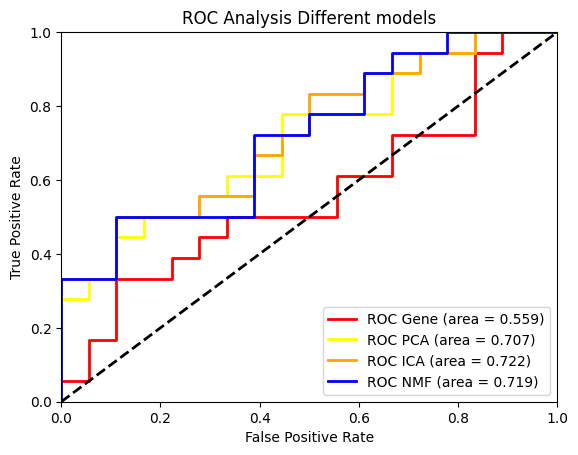

In [85]:
%matplotlib inline
plt.figure()
lw = 2
plt.plot(fprG_gene, tprG_gene, color='red',
         lw=lw, label='ROC Gene (area = %0.3f)' % roc_aucG_gene)
plt.plot(fprG_pca, tprG_pca, color='yellow',
         lw=lw, label='ROC PCA (area = %0.3f)' % roc_aucG_pca)
plt.plot(fprG_ica, tprG_ica, color='orange',
         lw=lw, label='ROC ICA (area = %0.3f)' % roc_aucG_ica)
plt.plot(fprG_nmf, tprG_nmf, color='blue',
         lw=lw, label='ROC NMF (area = %0.3f)' % roc_aucG_nmf)

plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Analysis Different models')
plt.legend(loc="lower right")
plt.show()
